In [ ]:
# Step 1: Uploading file in collab
from google.colab import files
uploaded = files.upload()

# Step 2: Load the dataset
import pandas as pd
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)



Saving Medicaldataset.csv to Medicaldataset (2).csv


Summary Statistics for Numerical Attributes:
               Age       Gender   Heart rate  Systolic blood pressure  Diastolic blood pressure  Blood sugar        CK-MB     Troponin
count  1319.000000  1319.000000  1319.000000              1319.000000               1319.000000  1319.000000  1319.000000  1319.000000
mean     56.193328     0.659591    78.336619               127.170584                 72.269143   146.634344    15.274306     0.360942
std      13.638173     0.474027    51.630270                26.122720                 14.033924    74.923045    46.327083     1.154568
min      14.000000     0.000000    20.000000                42.000000                 38.000000    35.000000     0.321000     0.001000
25%      47.000000     0.000000    64.000000               110.000000                 62.000000    98.000000     1.655000     0.006000
50%      58.000000     1.000000    74.000000               124.000000                 72.000000   116.000000     2.850000     0.014000
75%      6

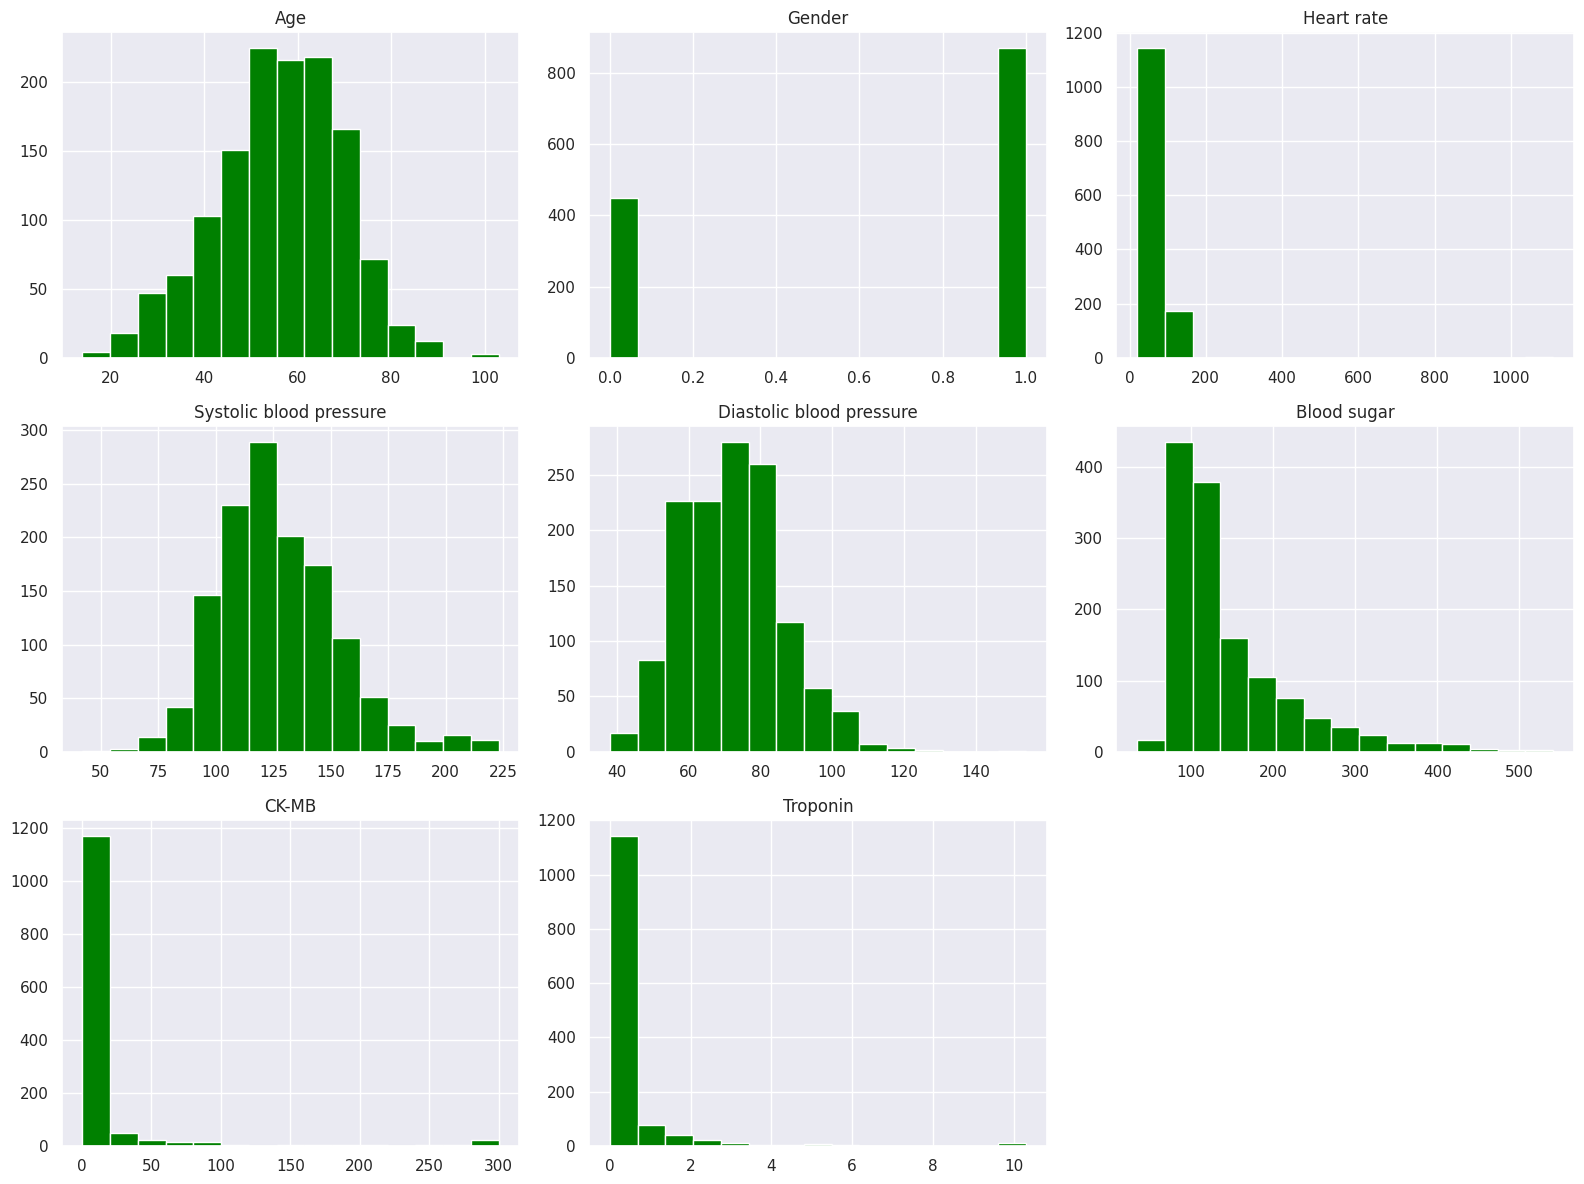

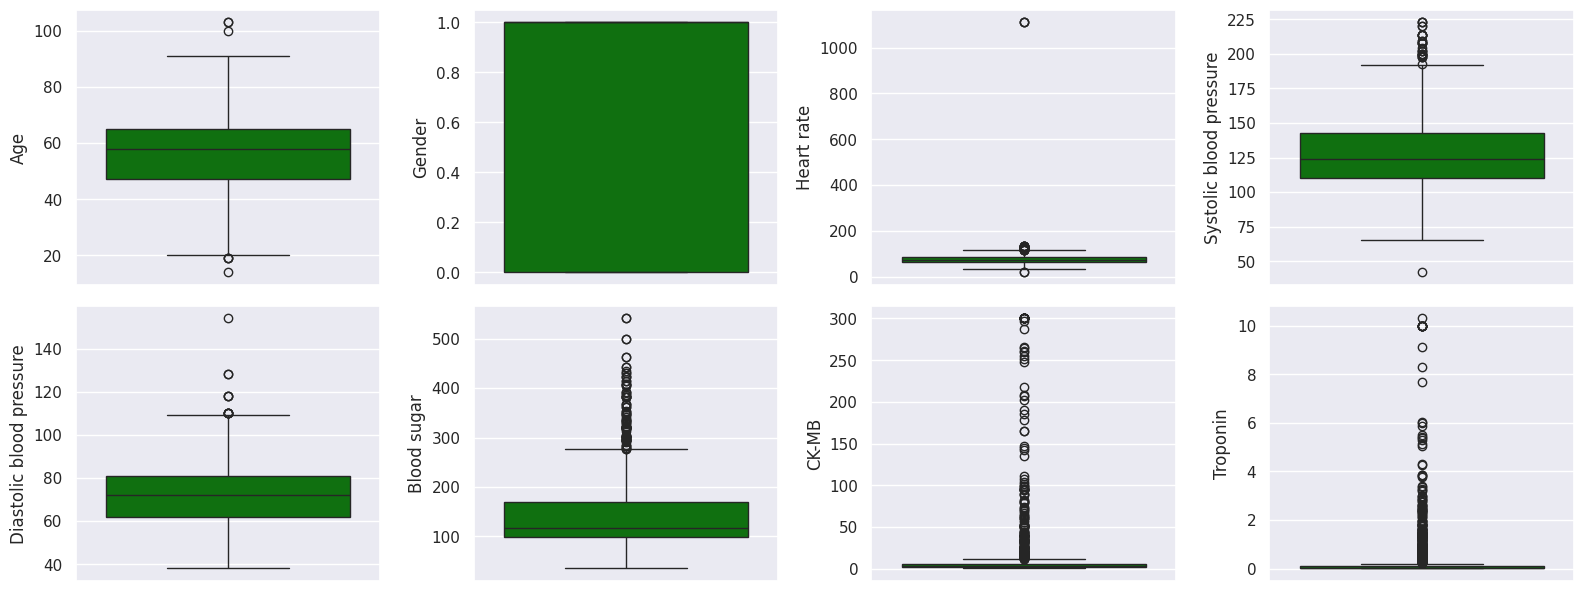

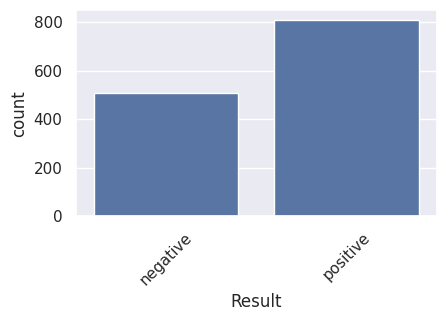

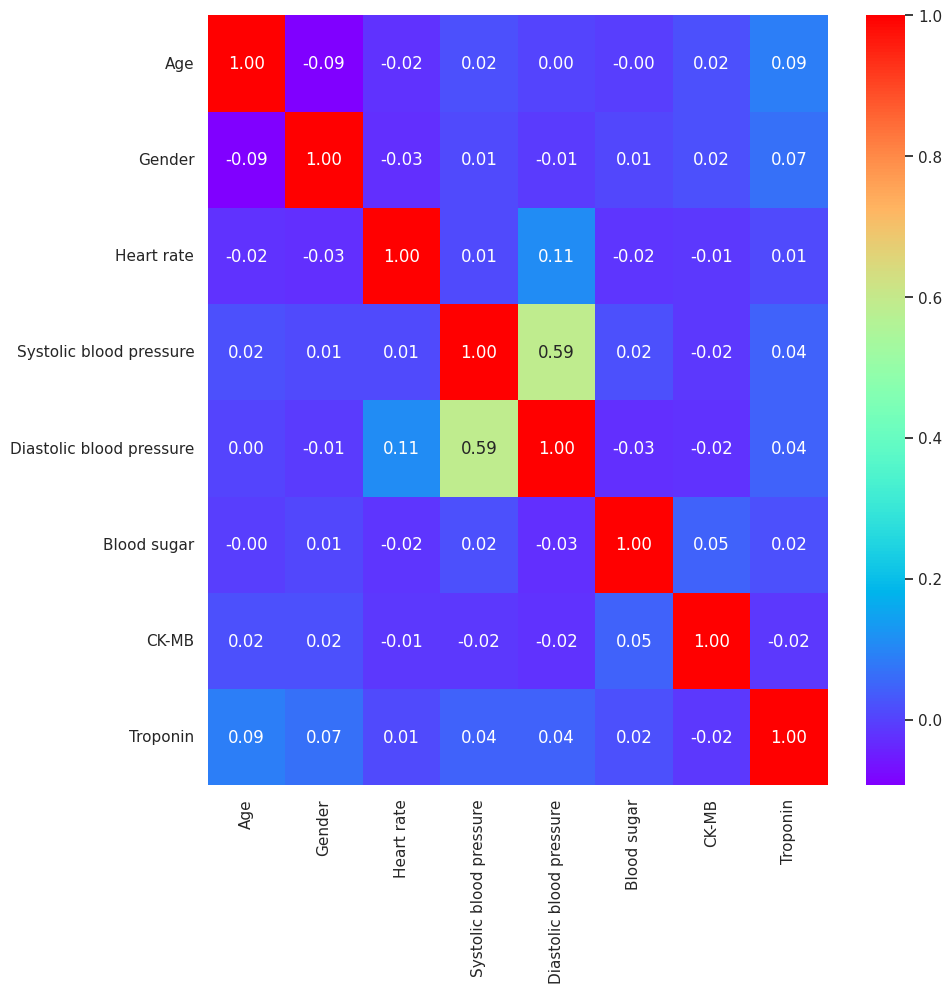

Missing Values in the Dataset:
Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64


In [ ]:
# Step 3: Importing Libraries and preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [15, 8]
sns.set()

# Display summary statistics for numerical attributes
numerical_attributes = df.select_dtypes(include=[np.number])
print("Summary Statistics for Numerical Attributes:")
print(numerical_attributes.describe())

# Visualize the distribution of numerical attributes
numerical_attributes.hist(figsize=(16, 12), bins=15, color="green")
plt.tight_layout()
plt.show()

# Boxplots for numerical attributes
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_attributes.columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=col, data=numerical_attributes, color="green")
plt.tight_layout()
plt.show()

# Count plots for categorical attributes
categorical_attributes = df.select_dtypes(include=['object'])
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_attributes.columns):
    plt.subplot(4, 4, i + 1)
    sns.countplot(x=col, data=categorical_attributes)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(numerical_attributes.corr(), annot=True, fmt=".2f", cmap='rainbow')
plt.show()

# Check for missing values
print("Missing Values in the Dataset:")
print(df.isnull().sum())

# Data encoding and splitting
df_preprocessed = df.copy()
label_encoder = LabelEncoder()
df_preprocessed['Result'] = label_encoder.fit_transform(df_preprocessed['Result'])

X = df_preprocessed.drop('Result', axis=1)
y = df_preprocessed['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical columns
scaler = StandardScaler()
numerical_cols = ['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])



In [ ]:
# Step 4: Feature Engineering
# This section involves creating new features like BMI and BP categories.

# Adding BMI as a feature
weight = 70  # in kilograms
height = 1.7  # in meters
BMI = weight / (height ** 2)
X_train['BMI'] = BMI
X_test['BMI'] = BMI

# Adding BP category as a feature
conditions = [
    (X_train['Systolic blood pressure'] < 120),
    (X_train['Systolic blood pressure'] >= 120) & (X_train['Systolic blood pressure'] <= 129),
    (X_train['Systolic blood pressure'] >= 130) & (X_train['Systolic blood pressure'] <= 139),
    (X_train['Systolic blood pressure'] >= 140)
]
categories = ['Normal', 'Elevated', 'High Stage 1', 'High Stage 2']
X_train['BP_Category'] = np.select(conditions, categories, default='Unknown')

conditions_test = [
    (X_test['Systolic blood pressure'] < 120),
    (X_test['Systolic blood pressure'] >= 120) & (X_test['Systolic blood pressure'] <= 129),
    (X_test['Systolic blood pressure'] >= 130) & (X_test['Systolic blood pressure'] <= 139),
    (X_test['Systolic blood pressure'] >= 140)
]
X_test['BP_Category'] = np.select(conditions_test, categories, default='Unknown')

bp_category_encoder = LabelEncoder()
X_train['BP_Category'] = bp_category_encoder.fit_transform(X_train['BP_Category'])
X_test['BP_Category'] = bp_category_encoder.transform(X_test['BP_Category'])



In [ ]:
# Section 3: Model Training

# This section trains models and evaluates them on the test set.

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100)
svc = SVC(probability=True)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

models = [log_reg, rf_clf, svc, xgb_clf]
model_names = ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost']

scores = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': []}

# Train and evaluate each model
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    scores['Model'].append(name)
    scores['Accuracy'].append(accuracy_score(y_test, y_pred) * 100)
    scores['Precision'].append(precision_score(y_test, y_pred) * 100)
    scores['Recall'].append(recall_score(y_test, y_pred) * 100)
    scores['F1-Score'].append(f1_score(y_test, y_pred) * 100)
    scores['AUC-ROC'].append(roc_auc_score(y_test, y_proba) * 100)

scores_df = pd.DataFrame(scores)
print(scores_df)




                 Model   Accuracy  Precision      Recall   F1-Score    AUC-ROC
0  Logistic Regression  79.924242  81.976744   86.503067  84.179104  88.462006
1        Random Forest  98.106061  98.170732   98.773006  98.470948  98.630262
2                  SVC  61.742424  61.742424  100.000000  76.346604  75.047075
3              XGBoost  97.727273  97.575758   98.773006  98.170732  99.125311


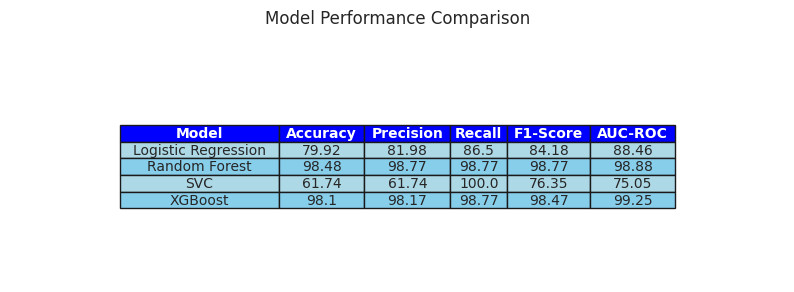

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

scores_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost'],
    'Accuracy': [79.92, 98.48, 61.74, 98.10],
    'Precision': [81.98, 98.77, 61.74, 98.17],
    'Recall': [86.50, 98.77, 100.00, 98.77],
    'F1-Score': [84.18, 98.77, 76.35, 98.47],
    'AUC-ROC': [88.46, 98.88, 75.05, 99.25],
}

# Convert the data to a pandas DataFrame
scores_df = pd.DataFrame(scores_data)

# Function to create a visual table with color
def plot_colored_data_table(dataframe, title="Model Performance Comparison"):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=dataframe.values,
        colLabels=dataframe.columns,
        cellLoc='center',
        loc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))

    # Apply colors (alternating skyblue and blue shades)
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('blue')
        elif row % 2 == 0:  # Even rows
            cell.set_facecolor('skyblue')
        else:  # Odd rows
            cell.set_facecolor('lightblue')

    plt.title(title, fontsize=12, pad=20)
    plt.show()

# Plot the data table with colors
plot_colored_data_table(scores_df)


In [ ]:
# Section 4: Hyperparameter Tuning
# -----------------------------------------------------------
# This section uses GridSearchCV for tuning the Random Forest model.
"""
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                           refit='f1',
                           cv=10,
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_clf = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_rf.pkl')
print("GridSearchCV results saved successfully!")

# Download the GridSearchCV object
files.download('grid_search_rf.pkl')



Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
GridSearchCV results saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

"""

best_params = grid_search.best_params_
best_rf_clf = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_rf.pkl')
print("GridSearchCV results saved successfully!")

# Download the GridSearchCV object
#files.download('grid_search_rf.pkl')



Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
GridSearchCV results saved successfully!


In [ ]:
from google.colab import files
uploaded = files.upload()
import joblib




Saving grid_search_rf.pkl to grid_search_rf (2).pkl


In [ ]:
# Load the GridSearchCV object
grid_search = joblib.load('grid_search_rf.pkl')

# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_rf_clf = grid_search.best_estimator_

print("Loaded GridSearchCV results successfully!")
print("Best Parameters:", best_params)

Loaded GridSearchCV results successfully!
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


CV Accuracy (Tuned): 98.96%
CV Precision (Tuned): 99.39%
CV Recall (Tuned): 98.76%
CV F1-Score (Tuned): 99.15%
CV AUC-ROC (Tuned): 99.88%


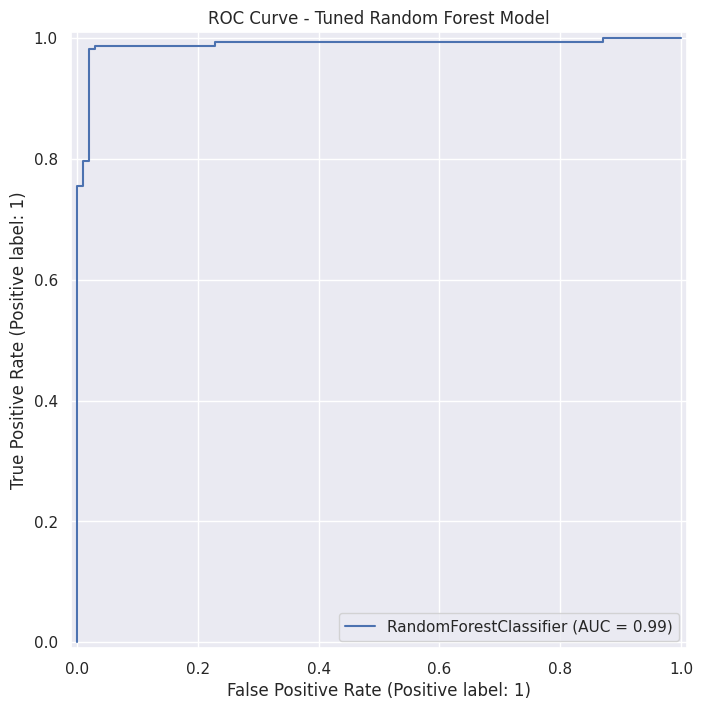

In [ ]:
# Section 5: Cross-Validation with Tuned Model
# -----------------------------------------------------------
# This section evaluates the tuned model using cross-validation.

cv_accuracy_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=10, scoring='accuracy')
cv_precision_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=10, scoring='precision')
cv_recall_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=10, scoring='recall')
cv_f1_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=10, scoring='f1')
cv_auc_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=10, scoring='roc_auc')

mean_cv_accuracy = np.mean(cv_accuracy_scores)
mean_cv_precision = np.mean(cv_precision_scores)
mean_cv_recall = np.mean(cv_recall_scores)
mean_cv_f1 = np.mean(cv_f1_scores)
mean_cv_auc = np.mean(cv_auc_scores)

print(f"CV Accuracy (Tuned): {mean_cv_accuracy * 100:.2f}%")
print(f"CV Precision (Tuned): {mean_cv_precision * 100:.2f}%")
print(f"CV Recall (Tuned): {mean_cv_recall * 100:.2f}%")
print(f"CV F1-Score (Tuned): {mean_cv_f1 * 100:.2f}%")
print(f"CV AUC-ROC (Tuned): {mean_cv_auc * 100:.2f}%")
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Fit the model on the entire training set (necessary to compute the ROC curve)
best_rf_clf.fit(X_train, y_train)

# Generate predicted probabilities for the positive class
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]

# Plot the ROC curve
RocCurveDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.title("ROC Curve - Tuned Random Forest Model")
plt.show()



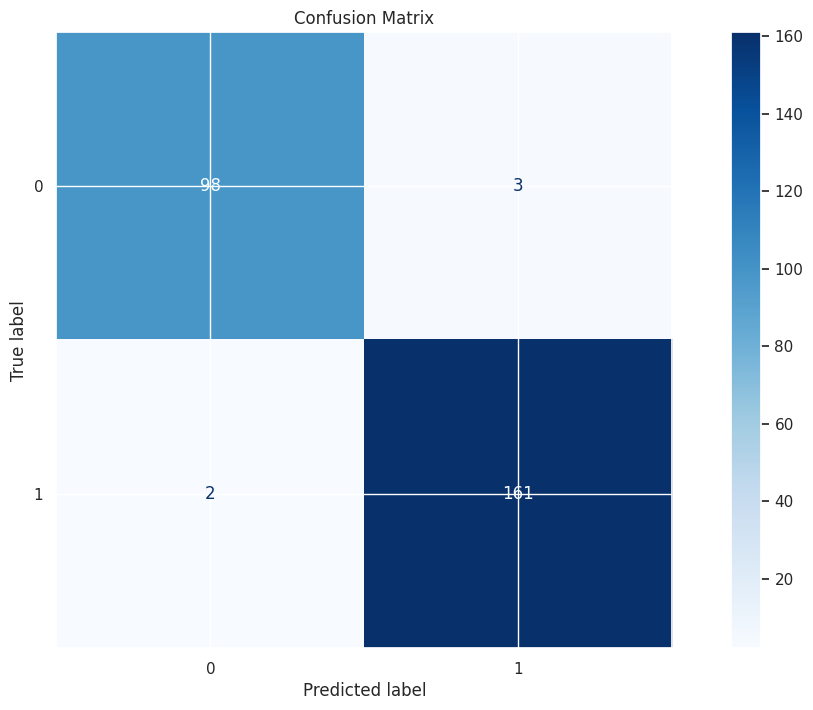

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       101
           1       0.98      0.99      0.98       163

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



In [ ]:
# Section 6: Confusion Matrix and Final Evaluation
# -----------------------------------------------------------
# This section evaluates the tuned model on the test set and displays the confusion matrix.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = best_rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
"""
index_to_drop = scores_df[scores_df['Model'] == 'Cross Validation'].index

# Drop the row by index
scores_df = scores_df.drop(index_to_drop, axis=0)

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Add the cross-validation results for the tuned model
new_cv_results = pd.DataFrame([{
    'Model': 'Cross Validation',
    'Accuracy': mean_cv_accuracy * 100
}])

# Append CV results to the scores DataFrame using pd.concat
scores_df = pd.concat([scores_df, new_cv_results], ignore_index=True)

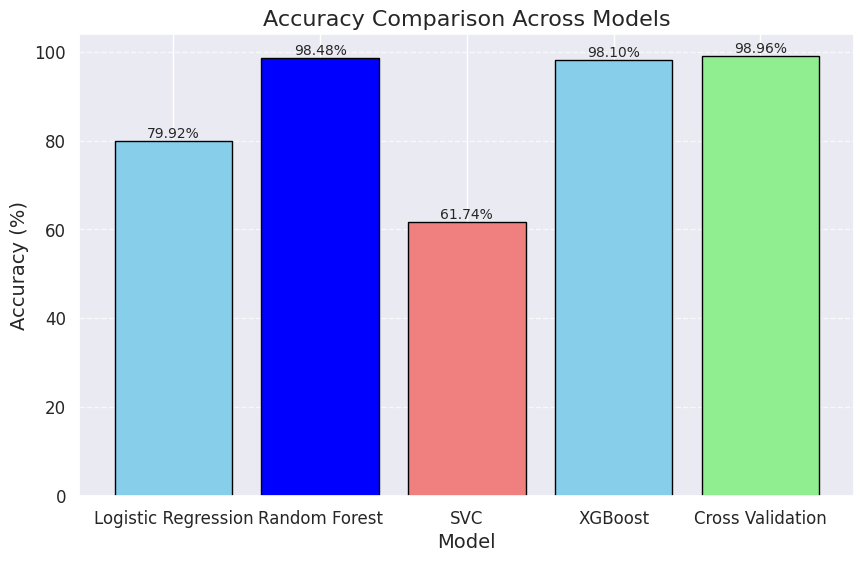

In [ ]:
# Define bar colors
colors = [
    'lightgreen' if model == 'Cross Validation' else
    'blue' if model == 'Random Forest' else
    'lightcoral' if model == 'SVC' else
    'skyblue'
    for model in scores_df['Model']
]
# Plot accuracies of all models
plt.figure(figsize=(10, 6))
plt.bar(scores_df['Model'], scores_df['Accuracy'], color= colors, edgecolor='black')
plt.title('Accuracy Comparison Across Models', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on the bars
for i, value in enumerate(scores_df['Accuracy']):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()
